# Performance of MetFrag and SIRIUS on the MassBank Data

For the performance evaluation, we are looking at the case where performance when only tandem mass-spectrometry (MS2) information is used.

In [4]:
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

from matchms import Spectrum

from ssvm.data_structures import CandSQLiteDB_Massbank
from ssvm.evaluation_tools import get_topk_performance_csifingerid

In [5]:
DB_FN = "../db/massbank__with_cfm_id.sqlite"
DB_URI = "file:" + DB_FN + "?mode=ro"
DB_CONN_RO = sqlite3.connect(DB_URI, uri=True)

In [18]:
molecule_identifier = "inchikey"
cands = CandSQLiteDB_Massbank(db_fn=DB_FN, molecule_identifier=molecule_identifier)

res = []

for idx, (ds, ) in enumerate(DB_CONN_RO.execute("SELECT distinct(dataset) FROM scored_spectra_meta")): 
    d_mf = {}
    d_sir = {}
    d_cfms = {}
    d_cfmm = {}
        
    for jdx, (acc, mol) in enumerate(DB_CONN_RO.execute(
        "SELECT accession, %s FROM scored_spectra_meta " \
        "   INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule " \
        "   INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset " \
        "   WHERE dataset IS ? AND retention_time >= 3 * column_dead_time_min" 
        % molecule_identifier,
        (ds, )
    )): 
        d_mf[jdx] = {}
        d_sir[jdx] = {}
        d_cfms[jdx] = {}
        d_cfmm[jdx] = {}
        
        spec = Spectrum(np.array([]), np.array([]), metadata={"spectrum_id": acc, "molecule_identifier": mol})
        
        # Get the label-space for the spectrum
        _lab_space = cands.get_labelspace(spec)
        d_mf[jdx]["n_cand"] = len(_lab_space)
        d_sir[jdx]["n_cand"] = len(_lab_space)
        d_cfms[jdx]["n_cand"] = len(_lab_space)
        d_cfmm[jdx]["n_cand"] = len(_lab_space)
        
        # Find the correct structure on the label-space
        _index_of_correct_structure = _lab_space.index(mol)
        d_mf[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        d_sir[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        d_cfms[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        d_cfmm[jdx]["index_of_correct_structure"] = _index_of_correct_structure
        
        # Get the MS2 scores
        d_mf[jdx]["score"] = cands.get_ms2_scores(spec, "metfrag__norm", scale_scores_to_range=False, return_as_ndarray=True)
        d_sir[jdx]["score"] = cands.get_ms2_scores(spec, "sirius__sd__correct_mf__norm", scale_scores_to_range=False, return_as_ndarray=True)
        d_cfms[jdx]["score"] = cands.get_ms2_scores(spec, "cfm-id__summed_up_sim__norm", scale_scores_to_range=False, return_as_ndarray=True)
        d_cfmm[jdx]["score"] = cands.get_ms2_scores(spec, "cfm-id__merge_pred_spec__norm", scale_scores_to_range=False, return_as_ndarray=True)
    
    _n_cand_med = np.median([d_mf[i]["n_cand"] for i in range(jdx)])
    _topk_mf = get_topk_performance_csifingerid(d_mf)
    _topk_sir = get_topk_performance_csifingerid(d_sir)
    _topk_cfms = get_topk_performance_csifingerid(d_cfms)
    _topk_cfmm = get_topk_performance_csifingerid(d_cfmm)
    
    print(ds)
    print(_n_cand_med)
    print(np.round(_topk_mf[1][[0, 4, 9, 19]], 1))
    print(np.round(_topk_sir[1][[0, 4, 9, 19]], 1))
    print(np.round(_topk_cfms[1][[0, 4, 9, 19]], 1))
    print(np.round(_topk_cfmm[1][[0, 4, 9, 19]], 1))
    
    # MetFrag
    res.append(
        [
            "MetFrag",                  # MS2-scorer
            ds,                         # dataset
            len(d_mf),                  # number of examples
            _n_cand_med                 # median number of candidates
        ] + _topk_mf[0].tolist()[:50],  # topk MetFrag
    )
    
    # SIRIUS
    res.append(
        [
            "SIRIUS",                    # MS2-scorer
            ds,                          # dataset
            len(d_sir),                   # number of examples
            _n_cand_med                  # median number of candidates
        ] + _topk_sir[0].tolist()[:50],  # topk MetFrag
    )
    
    # CDM-ID (sum)
    res.append(
        [
            "CFMID_SUM",                    # MS2-scorer
            ds,                          # dataset
            len(d_cfms),                   # number of examples
            _n_cand_med                  # median number of candidates
        ] + _topk_cfms[0].tolist()[:50],  # topk MetFrag
    )
    
    # CFM-ID (merged)
    res.append(
        [
            "CFMID_MERGED",                    # MS2-scorer
            ds,                          # dataset
            len(d_cfmm),                   # number of examples
            _n_cand_med                  # median number of candidates
        ] + _topk_cfmm[0].tolist()[:50],  # topk MetFrag
    )

AC_003
473.5
[ 3.  15.  23.8 36.5]
[ 6.4 25.1 39.7 53.4]
[ 2.  11.6 22.4 35.6]
[ 1.4  8.7 18.6 33.6]
AU_003
1561.0
[ 1.7 10.2 19.  31.9]
[26.6 51.8 61.3 68.1]
[ 1.5 10.6 19.7 29.3]
[ 1.5 13.2 23.  30.5]
AU_002
1364.0
[ 2.8 14.8 24.2 35.3]
[26.6 51.6 60.2 69. ]
[ 3.5 13.1 21.7 32.2]
[ 4.1 12.3 20.6 31.4]
AU_001
1036.0
[ 0.6  6.6 17.8 30.3]
[18.1 41.2 54.9 65.6]
[ 4.2 17.4 26.6 37. ]
[ 4.1 10.8 21.4 37.9]
BML_001
1349.0
[ 0.9  5.  10.2 17.5]
[12.4 40.  51.7 64.3]
[ 0.5  6.3 13.1 24.4]
[ 0.5  6.6 13.3 24.7]
CE_001
962.5
[ 0.7  4.4 11.5 15.7]
[16.6 55.2 65.9 74.7]
[ 0.   2.   4.1 14.7]
[ 0.   0.2  1.9 12.2]
EA_003
1519.0
[ 4.4 22.7 36.  51.9]
[39.8 70.  76.6 85.9]
[ 5.5 18.9 30.7 43. ]
[ 5.9 20.3 33.9 43.3]
EA_002
1586.5
[ 2.5 17.  29.7 41.4]
[28.5 55.2 64.8 74.1]
[ 3.6 17.1 26.5 36.1]
[ 3.2 17.6 25.3 34.1]
EQ_006
1391.0
[ 4.1 19.4 29.2 41. ]
[30.8 61.8 70.6 79.2]
[ 2.6 14.9 24.3 33.2]
[ 2.2 13.6 20.6 32. ]
EQ_004
1103.0
[ 4.5 19.5 30.8 45.1]
[24.6 50.6 62.6 72.5]
[ 4.9 17.5 29.6 41.7]
[ 6

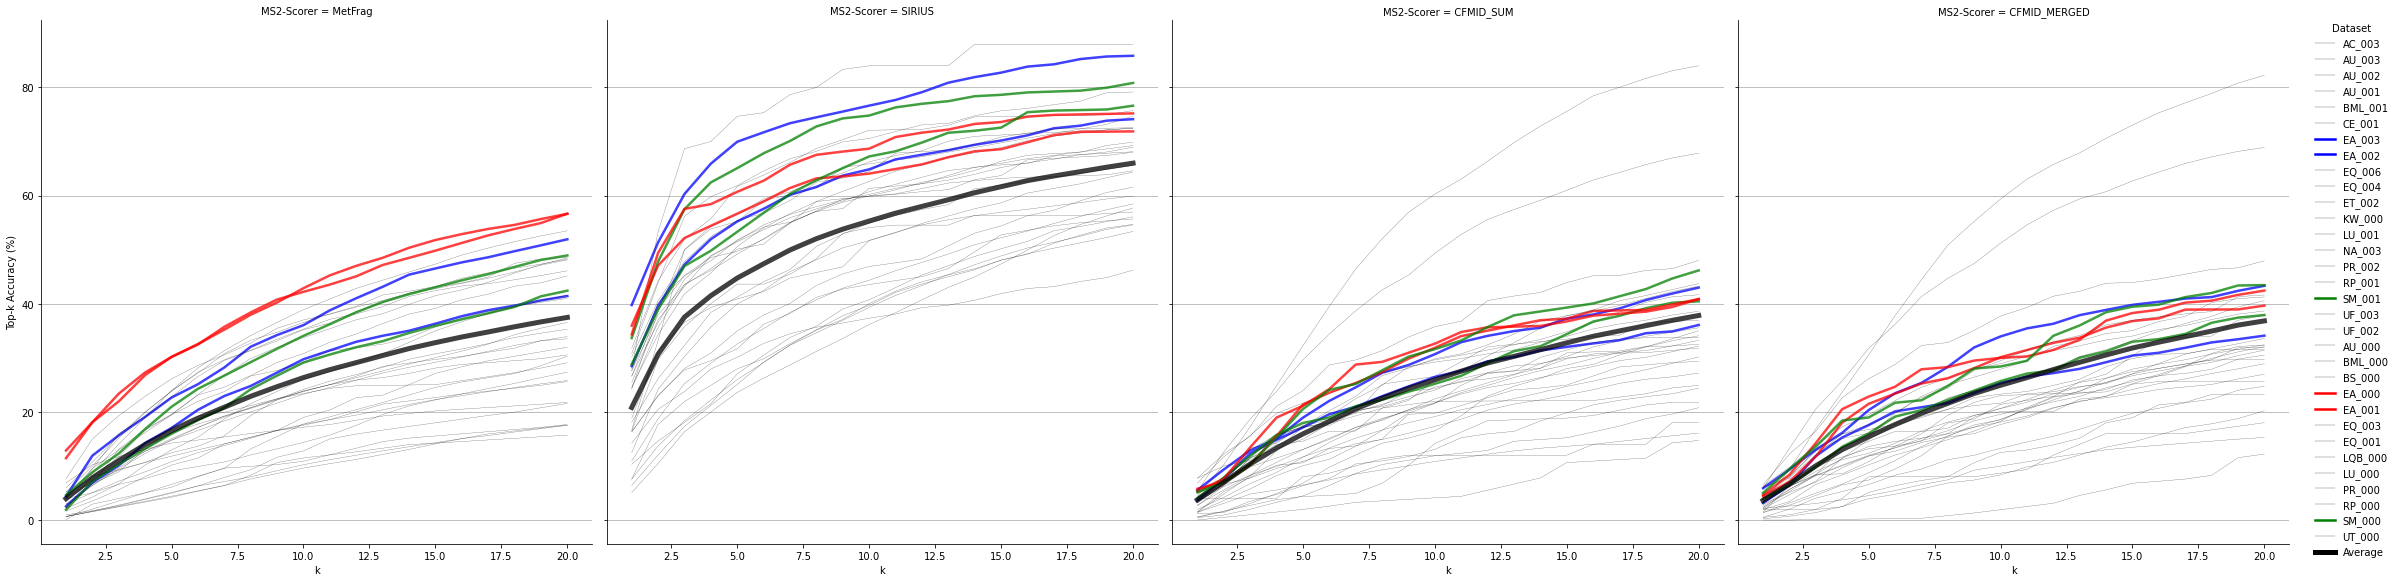

In [20]:
_columns = ["MS2-Scorer", "Dataset", "Number of Examples", "Median number of Candidates"]
_columns_k = [k + 1 for k in range(50)]
res_df = pd.DataFrame(res, columns=_columns + _columns_k).melt(id_vars=_columns, value_vars=_columns_k, value_name="topk", var_name="k")
res_df = res_df.assign(topk_acc=(res_df["topk"] / res_df["Number of Examples"] * 100))

res_df_avg = res_df \
    .groupby(["MS2-Scorer", "k"])[["Dataset", "Number of Examples", "topk"]] \
    .aggregate({"Dataset": lambda _: "Average", "Number of Examples": np.sum, "topk": np.sum}) \
    .reset_index()
res_df_avg = res_df_avg.assign(topk_acc=(res_df_avg["topk"] / res_df_avg["Number of Examples"] * 100))
res_df_avg = pd.concat((res_df, res_df_avg), axis=0)

_palette = {ds: "black" for _, ds, *_ in res}
_palette["Average"] = "black"
_palette["EA_000"] = "red"
_palette["EA_001"] = "red"
_palette["EA_002"] = "blue"
_palette["EA_003"] = "blue"
_palette["SM_000"] = "green"
_palette["SM_001"] = "green"

_sizes = {ds: 0.25 for _, ds, *_ in res}
_sizes["Average"] = 5
_sizes["EA_000"] = 2.5
_sizes["EA_001"] = 2.5
_sizes["EA_002"] = 2.5
_sizes["EA_003"] = 2.5
_sizes["SM_000"] = 2.5
_sizes["SM_001"] = 2.5

g = sns.relplot(
    data=res_df_avg[res_df_avg["k"] <= 20], 
    x="k", y="topk_acc", 
    size="Dataset", sizes=_sizes,
    hue="Dataset", palette=_palette,
    col="MS2-Scorer",
    legend="brief",
    kind="line",
    height=8,
    alpha=0.75
)
g.axes[0, 0].grid(axis="y")
g.axes[0, 1].grid(axis="y")
g.axes[0, 2].grid(axis="y")
g.axes[0, 3].grid(axis="y")
g.set_ylabels("Top-k Accuracy (%)")

In [ ]:
g = sns.catplot(data=res_df[res_df["k"].isin([1, 5, 10, 20])], x="Dataset", y="topk_acc", row="MS2-Scorer", col="k", kind="bar", sharey="col")
for c in range(4):
    ax = g.axes[1, c] 
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)